# Sobreajuste, Validación y Regularización


En el ejemplo del **regresor polinomial** vimos que aumentar el grado del polinomio vuelve más flexible al modelo, es decir que aumenta su capacidad para ajustar los datos

:::{note}

La cantidad de parámetros (grados de libertaed) del modelo es un proxy de su complejidad. Un modelo más complejo (más parámetros) es en general más flexible

:::

Sin embargo, si la flexibilidad es excesiva podríamos aproximar ciertos datos con error cero. Esta situación, en que el modelo "memoriza los datos", se conoce como **sobreajuste**

:::{warning}

Un modelo sobreajustado tiende a predecir muy mal datos "que no ha visto", es decir que pierde capacidad de **generalización**

:::

La siguiente figura esquematiza la relación la complejidad o capacidad de ajustar del modelo

<img src="img/overfitting.png" width="400">

Figura: https://www.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html

:::{note}

En general, mientras más simple (menos complejo) sea el modelo, menos propenso es a sobreajustarse

:::

:::{hint}

Podemos evitar el escenario sobreajustado en modelos complejos utilizando un conjunto de datos de validación o estrategias de regularización 

:::

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1234)
x = np.random.randn(30)
y = -0.5*x**4 + 2*x**3 -3 + np.random.randn(len(x))

## Estrategias de Validación

Para combatir el sobreajuste podemos usar **estrategias de validación**, estas se basan en separar el conjunto de datos en dos o más subconjuntos, revisemos dos de ellas

**Holdout**

Consiste en separar los datos en conjuntos de entrenamiento, validación y prueba:

- El primero se ocupa para entrenar o ajustar el modelo
- El segundo se utiliza para detectar sobreajuste y calibrar los hiperparámetros del modelo
- El tercero se ocupa para realizar una evaluación final libre de sesgos

Típicamente, la base de datos se particiona en proporción 80%, 10%, 10% si el dataset es grande o 60%, 20%, 20% si el dataset es pequeño

**K-fold**

La validación cruzada o K-fold consisten en separar el conjunto en $K$ particiones y utilizarlas alternadamente para entrenar y validar como muestra el siguiente esquema

<img src="img/cv.png" width="400">

El caso extremo se conoce como Leave-one-out (LOO), en que se entrena con todos los datos menos uno $N$ veces.


> Para ambos tipos de validación los conjuntos se seleccionan aleatoriamente. También puede hacerse de forma estratificada, es decir manteniendo la proporción de clases


Podemos separar un conjunto en dos con scikit-learn utilizando:

30 24 6


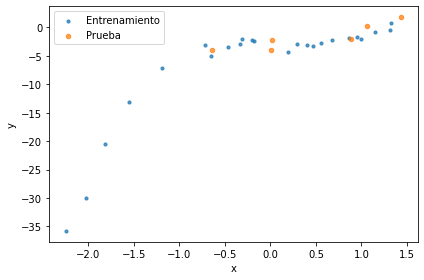

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(len(y), len(y_train), len(y_test))

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.scatter(X_train, y_train, s=10, label='Entrenamiento', alpha=0.75)
ax.scatter(X_test, y_test, s=20, label='Prueba', alpha=0.75)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y');

En el ejemplo del regresor polinomial podemos utilizar **validación cruzada** para seleccionar el grado de polinomio óptimo

Para esto utilizarmos la función [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Los argumentos principales de esta función son

- Un modelo de scikit learn
- Datos 
- Etiquetas
- `cv`: La cantidad de particiones (K)
- `scoring`: Un objeto `scorer` que implementa una métrica de evaluación

Podemos crear un objeto `scorer` a partir de una métrica de scikit-learn con

In [3]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error)

Veamos a continuación como se ocupa `cross_val_score` con el `scorer` que acabamos de crear 

Lo utilizaremos para encontrar el mejor grado del polinomio considerando 5 particiones para la validación cruzada

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

val_scores = []
train_scores = []
degrees = np.arange(1, 11, step=1)

for degree in degrees:
    # Modelo con validación
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))    
    val_scores.append(cross_val_score(model, X_train.reshape(-1, 1), y_train, cv=5, scoring=scorer))
    # Modelo sin validación 
    model.fit(X_train.reshape(-1, 1), y_train)
    train_scores.append(scorer(model, X_train.reshape(-1, 1), y_train))

score_mean = [score.mean() for score in val_scores]
degrees[np.argmin(score_mean)]

3

Si visualizamos los resultados:

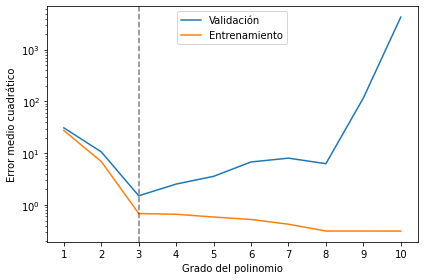

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(np.arange(1, len(score_mean)+1), score_mean, label='Validación')
ax.plot(np.arange(1, len(train_scores)+1), train_scores, label='Entrenamiento')
ax.axvline(3, ls='--', c='k', alpha=0.5)
ax.set_yscale('log')
ax.set_xticks(range(1, 11))
plt.legend()
ax.set_xlabel('Grado del polinomio')
ax.set_ylabel('Error medio cuadrático');

:::{note}

El regresor polinomial con menor error de validación es de grado 3

:::

En resumen

- Bajo error de entrenamiento y de validación: **Ideal**
- Bajo error de entrenamiento y alto error de validación: **Modelo sobreajustado**
- Alto error de entrenamiento y de validación: Considera un modelo de mayor complejidad y asegurate que tu código no tenga bugs


## Búsqueda de hiperparámetros con scikit-learn

Podemos automatizar aun más la búsqueda de hiperparámetros utilizando [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Los argumentos principales de esta clase son

- Un estimador (regresor o clasificador) de scikit-learn 
- `param_grid`: Un diccionario con los valores de los hiperparámetros que se han de explorar
- `cv`: La cantidad de particiones para la validación cruzada
- `scoring`: Una métrica que se utilizará para evaluar los modelos
- `n_jobs`: El número de núcleos de CPU

Para crear el diccionario de parámetros primero necesitamos conocer los nombres de los parámetros de nuestro modelo. Los estimadores de scikit-learn tienen un método `get_params()` que facilita esta tarea

Por ejemplo para el regresor polinomial:

In [6]:
model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))
model.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures(degree=10)),
  ('linearregression', LinearRegression(fit_intercept=False))],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(degree=10),
 'linearregression': LinearRegression(fit_intercept=False),
 'polynomialfeatures__degree': 10,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'linearregression__copy_X': True,
 'linearregression__fit_intercept': False,
 'linearregression__n_jobs': None,
 'linearregression__normalize': 'deprecated',
 'linearregression__positive': False}

Para hacer validación cruzada con el grado del polinomio debemos utilizar `polynomialfeatures__degree`

Por ejemplo:

In [7]:
params = {'polynomialfeatures__degree': range(1, 20)}

Es decir que probaremos los valores `degree` desde 1 a 19

El método principal de `GridSearchCV` es `fit(X, y)`. Este método realiza la validación cruzada con todas las combinaciones de hiperparámetros especificadas en `param_grid` y retorna la "mejor" según el `scorer` seleccionado

:::{warning}
            
Por convención `GridSearchCV` espera un `scorer` donde valores más grandes se consideran mejores que valores pequeños, es decir que maximiza en lugar de minimizar. Esto no es correcto para el error medio cuadrático

:::

Utilizando `greater_is_better=False` la métrica se multiplica por $-1$ y corregimos esa situación

In [8]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

Finalmente hacemos el ajuste con los parámetros y `scorer` escogidos

In [9]:
from sklearn.model_selection import GridSearchCV

validator = GridSearchCV(model, params, cv=5, scoring=scorer, verbose=True)
validator.fit(X_train.reshape(-1, 1), y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=10)),
                                       ('linearregression',
                                        LinearRegression(fit_intercept=False))]),
             param_grid={'polynomialfeatures__degree': range(1, 20)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=True)

Una vez realizado el ajuste podemos utilizar los principales atributos de la clase:

- `best_params_`: Retorna un diccionario que los hiperparámetros del mejor modelo
- `best_score_`: Retorna el error del mejor modelo
- `best_estimator_`: Retorna el estimador de mejor desempeño en validación



El mejor resultado en este caso es:

In [10]:
validator.best_params_, validator.best_score_

({'polynomialfeatures__degree': 3}, -1.5070219734256671)

:::{note}

`GridSearchCV` tiene también los métodos `predict` y `predict_proba` (siempre y cuando estos estén implementados en el estimador utilizado). Se retorna la predicción del mejor modelo según la validación cruzada

:::

In [23]:
x_extrapolate = np.linspace(-3, 2, 200)
y_extrapolate = validator.predict(x_extrapolate.reshape(-1, 1))

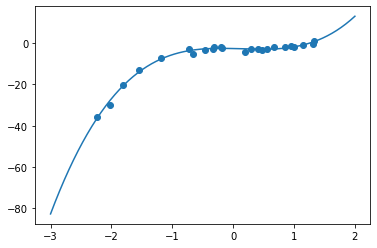

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_train, y_train)
ax.plot(x_extrapolate, y_extrapolate);

## Regularización

Considere las predicciones de los siguientes modelos

In [40]:
simple_model = make_pipeline(PolynomialFeatures(3), LinearRegression(fit_intercept=False))
simple_model.fit(X_train.reshape(-1, 1), y_train)
y_pred_simple = simple_model.predict(x_extrapolate.reshape(-1, 1))

complex_model = make_pipeline(PolynomialFeatures(20), LinearRegression(fit_intercept=False))
complex_model.fit(X_train.reshape(-1, 1), y_train)
y_pred_complex = complex_model.predict(x_extrapolate.reshape(-1, 1))

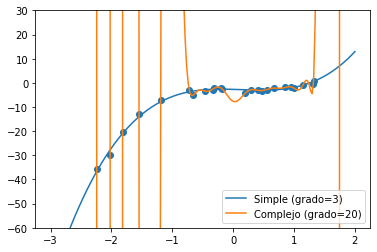

In [44]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_train, y_train)
ax.plot(x_extrapolate, y_pred_simple, label='Simple (grado=3)')
ax.plot(x_extrapolate, y_pred_complex, label='Complejo (grado=20)')
ax.set_ylim([-60, 30])
ax.legend(loc=4);

Respecto a este escenario William de Ockham enunció lo siguiente

```{epigraph}
...en igualdad de condiciones, la explicación más simple suele ser la más probable..
--- [William de Ockham](https://es.wikipedia.org/wiki/Guillermo_de_Ockham)
```

que se conoce como la navaja de Ockham o el principio de parsimonia


Otra forma de atacar el problema del sobreajuste es utilizando **regularización**

: Regularización
Concepto estadístico que consiste en guiar la optimización de un problema mediante una penalización adicional


Esto consiste en escoger el mejor modelo no sólo en base error sino también a su complejidad. 



:::{seealso}

[Una presentación sobre regresión que incluye métodos que no veremos en este curso](https://docs.google.com/presentation/d/1UUpK4zSdzRcS79V7_wU9nXe-sR7qYLEWhbmid-Rfp1k/edit?usp=sharing)

:::